In [19]:
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import (AutoTokenizer,
                          AutoConfig, 
                          AutoModelForSequenceClassification, 
                          TrainingArguments, 
                          Trainer,
                          DataCollatorWithPadding)
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.model_selection import train_test_split

# Загрузка размеченного датасета

In [43]:
# Загружаем данные
df = pd.read_csv('geo-reviews-dataset-2023.csv', header=0)
df.columns = ['review', 'label']
df = df[df['label'] != 0] # Избавимся от некорректных данных (хотя их быть не должно) (датасет на 5 оценок!)
df['label'] = df['label'] - 1

In [44]:
dups = df.pivot_table(index = ['label'], aggfunc ='size')
print(dups)

label
0     34288
1     12065
2     21635
3     41069
4    389169
dtype: int64


In [45]:
df_0 = df.loc[df['label'] == 0]
df_1 = df.loc[df['label'] == 1]
df_2 = df.loc[df['label'] == 2]
df_3 = df.loc[df['label'] == 3]
df_4 = df.loc[df['label'] == 4]

df_new = pd.concat([df_0[0:5000], df_1[0:5000], df_2[0:5000], df_3[0:5000], df_4[0:5000]], ignore_index=True)
df_new = df_new.sample(frac=1).reset_index(drop=True) #перемешать
df_new.shape

(25000, 2)

In [46]:
df_new.head()

,review,label
0,"Тут все пишут о том, как им не помогли в ветси...",0
1,"Стандартный сетевой магазин семейства магнит, ...",4
2,"Обожаю этот театр и актёров! Всем советую, пок...",4
3,"Воскресенье, полный центр детей, ребёнок хочет...",1
4,Частенько заезжаем покушать! Особенно баклажан...,3


In [ ]:
# будет необходимо для примера использования
"""test_df = pd.concat([df_0[3000:3600], df_1[3000:3600], df_2[3000:3600], df_3[3000:3600], df_4[3000:3600]], ignore_index=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)"""

# Предобработка отзывов

In [7]:
import re
# Оставим в тексте только кириллические символы
def clear_text(text):
    clear_text = re.sub(r'[^А-яЁё]+', ' ', text).lower()
    return " ".join(clear_text.split())

# напишем функцию удаляющую стоп-слова
def clean_stop_words(text, stopwords):
    text = [word for word in text.split() if word not in stopwords]
    return " ".join(text)

# загрузим список стоп-слов
stopwords = set(nltk_stopwords.words('russian'))
np.array(stopwords)

array({'много', 'чем', 'более', 'тут', 'уже', 'после', 'чтобы', 'чего', 'от', 'него', 'ну', 'три', 'под', 'зачем', 'совсем', 'за', 'всю', 'еще', 'сейчас', 'для', 'и', 'другой', 'впрочем', 'будет', 'почти', 'вдруг', 'себе', 'я', 'без', 'через', 'лучше', 'же', 'ей', 'на', 'к', 'вам', 'нет', 'тогда', 'всегда', 'мы', 'надо', 'из', 'когда', 'хоть', 'перед', 'она', 'ничего', 'два', 'их', 'а', 'может', 'так', 'ли', 'тебя', 'были', 'раз', 'всех', 'ней', 'кто', 'потом', 'такой', 'есть', 'но', 'до', 'там', 'какой', 'да', 'эти', 'нас', 'он', 'что', 'потому', 'им', 'ним', 'над', 'вот', 'вас', 'о', 'чтоб', 'нее', 'разве', 'была', 'ее', 'мне', 'себя', 'тем', 'больше', 'этом', 'или', 'нельзя', 'этого', 'бы', 'вы', 'этой', 'сам', 'опять', 'об', 'чуть', 'только', 'меня', 'как', 'мой', 'нибудь', 'во', 'иногда', 'при', 'них', 'конечно', 'ни', 'то', 'не', 'всего', 'наконец', 'ведь', 'эту', 'том', 'между', 'этот', 'был', 'теперь', 'они', 'по', 'тоже', 'куда', 'тот', 'можно', 'какая', 'быть', 'с', 'все', 'е

In [8]:
import time
import re
# Очистим тексты отзывов
start_clean = time.time()

df_new['review'] = df_new['review']\
     .apply(lambda x: clean_stop_words(clear_text(str(x)), stopwords))

print('Обработка текстов заняла: '+str(round(time.time() - start_clean, 2))+' секунд')

Обработка текстов заняла: 0.48 секунд


# Создание кастомной конфигурации

In [26]:
model_name = 'cointegrated/rubert-tiny2'

# Создаем свою конфигурацию
config = AutoConfig.from_pretrained(model_name)
config.num_labels = 5
config.id2label = {
    0: "очень отрицательный", 
    1: "отрицательный", 
    2: "нейтральный", 
    3: "положительный",
    4: "очень положительный"
}
config.label2id = {v: k for k, v in config.id2label.items()}

# Инициализируем модель с этой конфигурацией
model = AutoModelForSequenceClassification.from_config(config)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Подготовка датасетов

In [47]:
dataset = Dataset.from_pandas(df_new)

In [48]:
# Токенизация данных
def tokenize_function(examples):
    return tokenizer(examples['review'], truncation=True, padding=True, max_length=256) #, return_tensors=None)

In [49]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [54]:
# Разделение на train/validation/test tokenized_datasets['train']
tokenized_datasets = tokenized_datasets.train_test_split(test_size=0.3)
val_test_df = tokenized_datasets['test'].train_test_split(test_size=0.5)

# Создаем datasets
train_dataset = tokenized_datasets['train']
val_dataset = val_test_df['train']
test_dataset = val_test_df['test']

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 17500, Val: 3750, Test: 3750


# Настройка обучения с нуля

In [55]:
# Определяем метрики для оценки
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Основные метрики
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    
    # Детальный отчет
    report = classification_report(labels, predictions, output_dict=True)
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
    }

In [56]:
# Аргументы обучения
training_args = TrainingArguments(
    output_dir='./results_castom_model',
    overwrite_output_dir=True,
    
    # Стратегия обучения
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=1e-4,
    warmup_steps=1000,
    
    # Сохранение и оценка
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    
    # Оптимизации
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    
    # Для небольших датасетов
    dataloader_drop_last=False,
)

In [57]:
model.cuda() #убрать если отсутствует видеокарта в вашем ПК

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-

In [58]:
import torch
#device = torch.device('cpu')

In [60]:
# Создаем Data Collator для динамического дополнения последовательностей
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Создаем Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

C:\Users\andre\AppData\Local\Temp\ipykernel_4512\1454143875.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [61]:
# Запускаем обучение
trainer.train()

# Сохраняем модель
trainer.save_model('./my_custom_sentiment_model')
tokenizer.save_pretrained('./my_custom_sentiment_model')

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.194900,1.109891,0.511200,0.487875,0.483500,0.511200
2,0.933200,1.126507,0.524267,0.511319,0.508037,0.524267
3,0.720600,1.245655,0.529600,0.538906,0.555024,0.529600
4,0.500900,1.443610,0.526667,0.532579,0.543316,0.526667


('./my_custom_sentiment_model\\tokenizer_config.json',
 './my_custom_sentiment_model\\special_tokens_map.json',
 './my_custom_sentiment_model\\vocab.txt',
 './my_custom_sentiment_model\\added_tokens.json',
 './my_custom_sentiment_model\\tokenizer.json')

# Тестирование

In [89]:
# Тестирование на тестовой выборке
test_results = trainer.evaluate(test_dataset)
print("\nРезультаты на тестовой выборке:")
for key, value in test_results.items():
    print(f"{key}: {value:.4f}")

# Предсказание на новых данных
def predict_sentiment(texts):
    inputs = tokenizer(
        texts, 
        padding=True, 
        truncation=True, 
        max_length=512, 
        return_tensors="pt"
    )
    
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
    
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_classes = torch.argmax(predictions, dim=-1)
    
    results = []
    for i, text in enumerate(texts):
        results.append({
            'text': text,
            'predicted_class': predicted_classes[i].item(),
            'predicted_label': config.id2label[predicted_classes[i].item()],
            'confidence': predictions[i][predicted_classes[i]].item(),
            'probabilities': predictions[i].numpy()
        })
    
    return results


Результаты на тестовой выборке:
eval_loss: 1.2700
eval_accuracy: 0.5171
eval_f1: 0.5251
eval_precision: 0.5399
eval_recall: 0.5171
eval_runtime: 5.9452
eval_samples_per_second: 630.7610
eval_steps_per_second: 39.5280
epoch: 4.0000


# Ещё тесты

In [80]:
model = AutoModelForSequenceClassification.from_pretrained('./my_custom_sentiment_model')
tokenizer = AutoTokenizer.from_pretrained('./my_custom_sentiment_model')

# Функция для предсказания настроения
def predict_sentiment(text):
    # Токенизируем текст и подготавливаем для модели
    inputs = tokenizer(text, max_length=512, padding=True, truncation=True, return_tensors='pt')
    
    # Подаем на вход модели без вычисления градиентов (только инференс)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Получаем предсказания
    predicted = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    # Находим индекс класса с максимальной вероятностью
    predicted_class_idx = predicted.argmax().item()
    sentiment = predicted_class_idx #classes[predicted_class_idx]
    confidence = predicted[0][predicted_class_idx].item()
    
    return sentiment, confidence

In [ ]:
# Пример использования
# Очистим тексты отзывов
"""test_df['review'] = test_df['review']\
     .apply(lambda x: clean_stop_words(clear_text(str(x)), stopwords))"""

In [81]:
test_df = pd.concat([df_0[7000:7700], df_1[7000:7700], df_2[7000:7700], df_3[7000:7700], df_4[7000:7700]], ignore_index=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [82]:
test_df['prediction'] = test_df['review']\
        .apply(lambda x: predict_sentiment(str(x))[0])
test_df.head()

,review,label,prediction
0,Безобразное место!!! Квалификация врачей нулев...,0,0
1,Походит к концу наш отдых в МореЛето! О плюса...,2,2
2,Пришлось уезжать именно с него. Не понравился.,2,3
3,"Выбор есть, но мало свежих молочных продуктов ...",2,3
4,Персонал выше всяких похвал. Профессионалы с б...,4,4


In [83]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from plotly.subplots import make_subplots
import plotly.graph_objects as go

matrix = confusion_matrix(test_df['label'], test_df['prediction'])
print(np.matrix(matrix))

[[405 221  60   8   6]
 [163 302 200  27   8]
 [ 52 181 343 112  12]
 [ 10  42 241 326  81]
 [  7  18  58 163 454]]


In [84]:
test_df['spread_distance'] = ((test_df['label'] - test_df['prediction']) ** 2)
test_df.head()

,review,label,prediction,spread_distance
0,Безобразное место!!! Квалификация врачей нулев...,0,0,0
1,Походит к концу наш отдых в МореЛето! О плюса...,2,2,0
2,Пришлось уезжать именно с него. Не понравился.,2,3,1
3,"Выбор есть, но мало свежих молочных продуктов ...",2,3,1
4,Персонал выше всяких похвал. Профессионалы с б...,4,4,0


In [85]:
dups = test_df.pivot_table(index = ['spread_distance'], aggfunc ='size')
print(dups)

spread_distance
0     1830
1     1362
4      251
9       44
16      13
dtype: int64


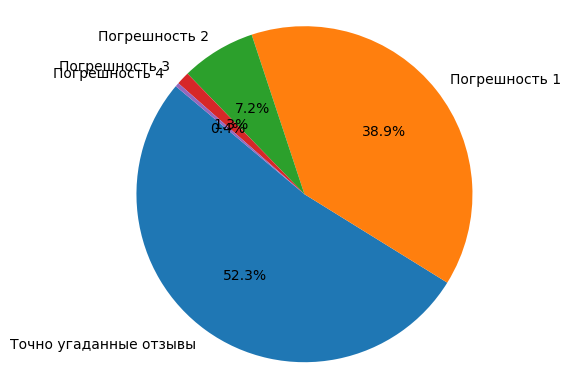

In [86]:
from matplotlib import pyplot as plt

sizes = [dups[0], dups[1], dups[4], dups[9], dups[16]]
labels = ['Точно угаданные отзывы', 'Погрешность 1', 'Погрешность 2', 'Погрешность 3', 'Погрешность 4']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140) 
plt.axis('equal')
plt.show() 

In [88]:
from sklearn.metrics import classification_report
accuracy = accuracy_score(test_df['label'], test_df['prediction'])
report = classification_report(test_df['label'], test_df['prediction'])

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.5228571428571429
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.58      0.61       700
           1       0.40      0.43      0.41       700
           2       0.38      0.49      0.43       700
           3       0.51      0.47      0.49       700
           4       0.81      0.65      0.72       700

    accuracy                           0.52      3500
   macro avg       0.55      0.52      0.53      3500
weighted avg       0.55      0.52      0.53      3500



In [91]:
c = 0
for j in range(5):
    for i, row in test_df.iterrows():  
        if (row['label'] == row['prediction']-1) and (row['label'] == j):
            c += 1
    print(f'Количество истинных оценок {j+1}: 700\
        Количество оценок предсказанных на 1 больше {j+1}: {c}')
    c = 0

Количество истинных оценок 1: 700        Количество оценок предсказанных на 1 больше 1: 221
Количество истинных оценок 2: 700        Количество оценок предсказанных на 1 больше 2: 200
Количество истинных оценок 3: 700        Количество оценок предсказанных на 1 больше 3: 112
Количество истинных оценок 4: 700        Количество оценок предсказанных на 1 больше 4: 81
Количество истинных оценок 5: 700        Количество оценок предсказанных на 1 больше 5: 0
